**EXPERIMENT 6**

**AIM:**

Implementation of inflated 3D CNN for action recognition

**THEORY AND SOURCE CODE**

Inflated 3D CNN (Convolutional Neural Network) is a deep learning architecture used for video recognition tasks. This model uses a pre-trained 2D CNN on large-scale image classification datasets such as ImageNet, and then "inflates" it to work with 3D convolutional layers to extract spatio-temporal features from video data. 

The basic idea behind Inflated 3D CNN is that the first few layers of the 2D CNN can be directly reused in the 3D CNN, since the lower-level image features learned in the 2D CNN are also useful for video data. The 2D CNN is then "inflated" to 3D by replicating the learned 2D filters across the time dimension to create 3D filters.

This approach has several advantages. First, using pre-trained 2D CNN weights saves time and computational resources, since training a 3D CNN from scratch can be time-consuming and require a large amount of data. Second, inflating the 2D CNN to 3D allows the model to learn spatio-temporal features that are specific to video data, which can improve the accuracy of the model for video recognition tasks. 

Inflated 3D CNN has been used in various applications such as action recognition, human pose estimation, and gesture recognition. However, it is worth noting that this approach may not be optimal for all video recognition tasks, as it assumes that the lower-level features learned in the 2D CNN are useful for the specific video dataset at hand. Therefore, careful consideration should be given to the choice of pre-trained 2D CNN and the specific video dataset being used.

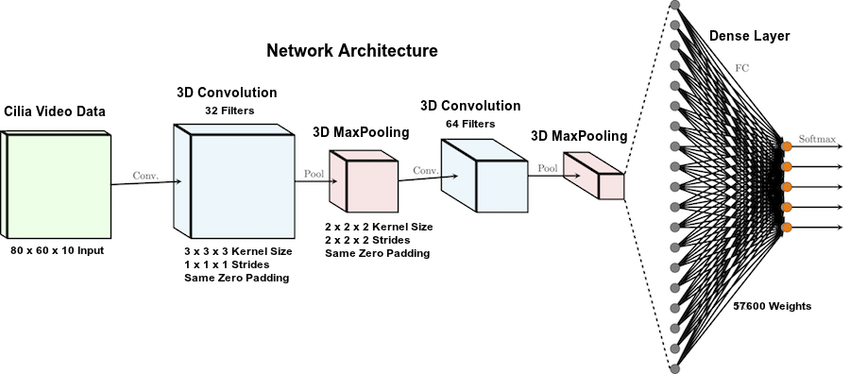

In [1]:
import imageio
import logging
from IPython import display
import os
import random
import re 

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import tempfile
import ssl
import numpy as np 

In [3]:
from IPython import display
from absl import logging
import imageio
import cv2 

In [4]:
from urllib import request
from urllib.request import *
from urllib.error import *

In [5]:
UCF_URL = "https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/"
VIDEO_LIST = None 

In [6]:
CACHE_DIR = tempfile.mkdtemp()
unverified = ssl._create_unverified_context()

In [7]:
def list_ucf_videos():
   global VIDEO_LIST
   if not VIDEO_LIST:
     index = request.urlopen(UCF_URL, context=unverified).read().decode("utf-8")
     videos = re.findall("(v_[\w_]+\.avi)", index)
     VIDEO_LIST = sorted(set(videos))
   return list(VIDEO_LIST)

In [15]:
def fetch(video):
   '''
   condition for existing video
   '''
   path = os.path.join(CACHE_DIR, video)
   '''
   for a new video, define a ,
   path using requests, url
   '''
   if not os.path.exists(path):
     url_path = request.urljoin(UCF_URL, video)
     print("Fetching %s => %s" % (url_path, path))
     data = request.urlopen(url_path, context=unverified).read()
     '''
     writing all of this into the file 
     '''
     open(path, "wb").write(data)
   return path 

In [16]:
def crop_center(frame):
   '''
   frame shape 
   '''
   y, x = frame.shape[0:2]
   min_dimension = min(y, x)
   '''
   setting start points for 
   both the dimensions
   '''
   starting_x = (x // 2) - (min_dimension // 2)
   starting_y = (y // 2) - (min_dimension // 2)
   '''
   returning limits to dimensions
   '''
   return frame[starting_y:starting_y+min_dimension,starting_x:starting_x+min_dimension]

def load(path, max_frames=0, resize=(224, 224)):
   '''
   variable to capture paths
   '''
   cap = cv2.VideoCapture(path)
   frames = []
   try:
     while True:
       ret, frame = cap.read()
       if not ret:
         break
       '''
       applying all above mentioned functions 
       video processing
       '''  
       frame = crop_center(frame)
       frame = cv2.resize(frame, resize)
       frame = frame[:, :, [2, 1, 0]]
       frames.append(frame)
       if len(frames) == max_frames:
         break
   finally:
     cap.release()
   '''
   dividing by 255 to get values 
   b/w 0-1
   '''  
   return np.array(frames) / 255.0

def gif(images):
   '''
   cliping the images for gif
   '''
   converted = np.clip(images * 255, 0, 255).astype(np.uint8)
   '''
   save gif of 25 frames 
   '''
   imageio.mimsave('./animation.gif', converted, fps=25)
   return embed.embed_file('./animation.gif')

In [17]:
# Get the kinetics-400 action labels from the GitHub repository.
KINETICS_URL = "https://raw.githubusercontent.com/deepmind/kinetics-i3d/master/data/label_map.txt"
with request.urlopen(KINETICS_URL) as obj:
   labels = [line.decode("utf-8").strip() for line in obj.readlines()]
print("Found %d labels." % len(labels)) 

Found 400 labels.


In [ ]:
videos = list_ucf_videos()
'''
 empty dict. for storing
'''
categories = {}
'''
 running loop on videos 
 from above function called
 '''
for video in videos:
   cat = video[2:-12]
   '''
   if not present add the video
   '''
   if cat not in categories:
     categories[cat] = []
   categories[cat].append(video)
   '''
   string formatting for showing output
   easily
   '''
print("Found %d videos in %d categories." % (len(videos), len(categories)))
for cat, seq in categories.items():
   '''
   join is used to remove the seperator and 
   concatenate the objects
   '''
   summary = ", ".join(seq[:2])
   print("%-20s %4d videos (%s, ...)" % (categories, len(seq), summary))

In [19]:
model = hub.load("https://tfhub.dev/deepmind/i3d-kinetics-400/1").signatures['default']

In [20]:
import urllib.request
import cv2

In [21]:
path = fetch('v_CricketShot_g04_c02.avi')
sample_video = load(path) 

Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_CricketShot_g04_c02.avi => C:\Users\Shivansh\AppData\Local\Temp\tmpt34slp3v\v_CricketShot_g04_c02.avi



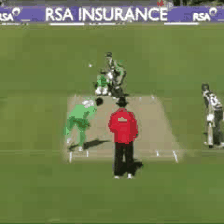

In [27]:
gif(sample_video)

In [23]:
def pred(sample_video):
   '''
   Model input 
   '''  
   model_input = tf.constant(sample_video, dtype=tf.float32)[tf.newaxis, ...]
   '''
   saving logits and probabilities of each 
   prediction
   '''
   log = model(model_input)['default'][0]
   prob = tf.nn.softmax(log)
   print("Printing Top 5 actions:")
   for i in np.argsort(prob)[::-1][:5]:
     print(f"  {labels[i]:22}: {prob[i] * 100:5.2f}%")
'''
 calling the function for 
 prediction
'''
pred(sample_video)

Printing Top 5 actions:
  playing cricket       : 97.77%
  skateboarding         :  0.71%
  robot dancing         :  0.56%
  roller skating        :  0.56%
  golf putting          :  0.13%
